# HW 4 #
## Due: Nov 5th 11:59 PM ##
## Total points: 80 ##

## Name(s) and EID(s):

If you prefer, you can work in groups of two. **Please note that only one student per team needs to submit the assignment but make sure to include both students' names and UT EIDs.**  

For any question that requires a handwritten solution, you may upload scanned images of your solution in the notebook or attach them to the assignment . You may write your solution using markdown as well.

Please make sure your code runs and the graphs and figures are displayed in your notebook and PDF before submitting.

###  Q1. (10 points) Binary Classifier
    
Consider the Covid-test scenario, where we have a test output Y = $\{0,1\}$ and the true value H = $\{0,1\}$. We also know the sensitivity (ie, $\mathbb{P} (Y=1|H=1)$) to be $87.5\%$ and specificity (ie, $\mathbb{P} (Y=0|H=0)$) to be $97.5\%$. However, the prevalence of Covid in the area of interest (ie, the prior) $\mathbb{P} (H=1)$ is not precisely known, and hence the below question:
    
a. (5 points) Calculate $\mathbb{P} (H=1|Y=1)$ and $\mathbb{P} (H=1|Y=0)$ for different values of prior $\mathbb{P} (H=1)$ = $\{0.01, 0.1, 0.2, 0.5\}$. Plot them w.r.t the different values of prior.
    
b. (5 points) There is a cheaper test, with same sensitivity (ie, detects Covid +ve at the same rate) but with a reduced specificity of $90\%$(ie, tells healthy people that they are +ve, with a higher rate). Hence plot the same chart as in part a. with the new value of specificity.
    


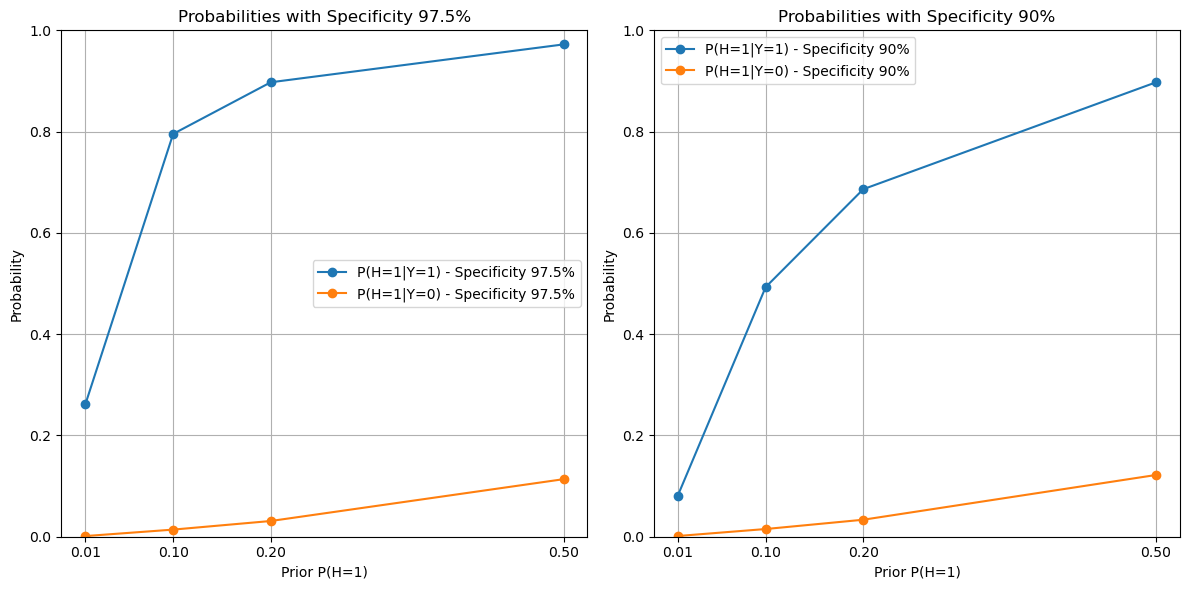

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Given probabilities
sensitivity = 0.875
specificity_1 = 0.975
specificity_2 = 0.90
prior_values = np.array([0.01, 0.1, 0.2, 0.5])

# Function to calculate probabilities using Bayes' theorem
def calculate_probabilities(prior, sensitivity, specificity):
    # Calculate prior probability of H=0
    prior_H0 = 1 - prior
    
    # Calculate P(Y=1) and P(Y=0) using total probability
    P_Y1 = sensitivity * prior + (1 - specificity) * prior_H0
    P_Y0 = (1 - sensitivity) * prior + specificity * prior_H0
    
    # Calculate P(H=1|Y=1) and P(H=1|Y=0) using Bayes' theorem
    P_H1_Y1 = (sensitivity * prior) / P_Y1
    P_H1_Y0 = ((1 - sensitivity) * prior) / P_Y0
    
    return P_H1_Y1, P_H1_Y0

# Store results for plotting for the first specificity
results_1 = np.array([calculate_probabilities(prior, sensitivity, specificity_1) for prior in prior_values])
P_H1_Y1_1, P_H1_Y0_1 = results_1[:, 0], results_1[:, 1]

# Store results for plotting for the second specificity
results_2 = np.array([calculate_probabilities(prior, sensitivity, specificity_2) for prior in prior_values])
P_H1_Y1_2, P_H1_Y0_2 = results_2[:, 0], results_2[:, 1]

# Plotting
plt.figure(figsize=(12, 6))

# Plot for the first specificity
plt.subplot(1, 2, 1)
plt.plot(prior_values, P_H1_Y1_1, marker='o', label='P(H=1|Y=1) - Specificity 97.5%')
plt.plot(prior_values, P_H1_Y0_1, marker='o', label='P(H=1|Y=0) - Specificity 97.5%')
plt.title('Probabilities with Specificity 97.5%')
plt.xlabel('Prior P(H=1)')
plt.ylabel('Probability')
plt.xticks(prior_values)
plt.ylim(0, 1)
plt.grid()
plt.legend()

# Plot for the second specificity
plt.subplot(1, 2, 2)
plt.plot(prior_values, P_H1_Y1_2, marker='o', label='P(H=1|Y=1) - Specificity 90%')
plt.plot(prior_values, P_H1_Y0_2, marker='o', label='P(H=1|Y=0) - Specificity 90%')
plt.title('Probabilities with Specificity 90%')
plt.xlabel('Prior P(H=1)')
plt.ylabel('Probability')
plt.xticks(prior_values)
plt.ylim(0, 1)
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()


# Q2. Classification with Skorch (25 points)

In this question we will train and evaluate a simple neural network on a classification dataset using the skorch library. skorch is a scikit-learn compatible neural network library that wraps PyTorch. For more details on how to use the library see [here](https://github.com/skorch-dev/skorch). For this question, we will use a phishing dataset which consists of 11430 URLs with 87 extracted features. The dataset is already preprocessed and provided to you in the file `phishing_dataset.pt`. The dataset is balanced i.e. it contains 50% phishing and 50% legitimate URLs.


In [9]:
!pip install skorch mpld3

In [1]:
import torch
import numpy as np
import pandas as pd
from torch import nn
from skorch import NeuralNetClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, roc_curve, auc, RocCurveDisplay, ConfusionMatrixDisplay, accuracy_score, classification_report
import matplotlib.pyplot as plt

In [11]:
from google.colab import files
uploaded = files.upload()

ModuleNotFoundError: No module named 'google.colab'

In [2]:
X_train, y_train, X_train_imbalanced, y_train_imbalanced, X_test, y_test, X_test_imbalanced, y_test_imbalanced = torch.load('phishing_dataset_final.pt')

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_18268\950230015.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  X_train, y_train, X_train_imbalanced, y_train_imbalanced, X_

## Part 1. (9 points)

In this part we will define our neural network. When building our network we will take as input the following:
1. inp_size: the number of input features
2. hidden_sizes: list of the size of each hidden layer in the network. Note that this does not include the size of the input and output layer. Eg: `[16, 8]` in which case your NN will look like: input_layer -> hidden_layer_1 (size 16) -> hidden_layer_2 (size 8) -> output_layer.
3. num_classes: the number of output classes which is equivalent to the size of the output layer. In our example, we only have 2 classes (phishing, non-phishing).
4. nonlin: the activation function. Eg: `torch.nn.ReLU()`.

The above arguments will be used to initialize our neural network. Notice that we want to be able to initialize an arbitrary size network specified by the hidden_sizes. To do this you must first initialize a `nn.ModuleList()` and append your layer followed by the activation for each specified size. You can refer to [this](https://pytorch.org/docs/stable/generated/torch.nn.ModuleList.html) for more help.

You must also define a `forward(X)` function which handles the forward pass of your network. Here `X` is your input and you must return the [softmax](https://pytorch.org/docs/stable/generated/torch.nn.Softmax.html) output tensor from your network in this function.

In [3]:
class MyModule(nn.Module):
    def __init__(self, inp_size, hidden_sizes, num_classes=2, nonlin=nn.ReLU()):
        super().__init__()
        # define your hidden layers (self.hidden) as a nn.ModuleList() and append your nn.Linear layers based on the hidden_sizes
        ##  START CODE  ##
        self.hidden = nn.ModuleList()
        previous_size = inp_size
        for size in hidden_sizes:
            self.hidden.append(nn.Linear(previous_size, size))
            self.hidden.append(nonlin)  # Append activation function
            previous_size = size
        ##  END CODE  ##
        # Define output layer
        self.output_layer = nn.Linear(previous_size, num_classes)

        # define softmax
        ##  START CODE  ## (1 line of code)
        self.softmax = nn.Softmax(dim=1)
        ##  END CODE  ##

    def forward(self, X):
        # calculate the output from your hidden layers
        # Hint: if your hidden layers are in the form of nn.ModuleList(),
        #       you must write a for loop to do a forward pass on all layers in the list
        ##  START CODE  ##
        for layer in self.hidden:
            X = layer(X)
        ##  END CODE  ##

        # calculate softmax on the output
        ##  START CODE  ## (1 line of code)
        out = self.output_layer(X)
        out = self.softmax(out)        ##  END CODE  ##
        return out

## Part 2. (5 points)

In this part we will train and evaluate the neural network on our dataset. Use `X_train` and `y_train` tensors to train the model. Use `X_test` and `y_test` tensors to evaluate.  **To get full credit you must obtain an accuracy of 95% or more on the test set.** You must use GridSearchCV from sklearn to search the best hyperparameters. Search over atleast 2 values (can be anything of your choice) of the following hyperparams:
1. Learning rate
2. Number of training epochs
3. hidden_sizes which is the input to your neural network you defined above
4. nonlin which is the activation function input to your neural network you defined above

Finally, use sklearn's ConfusionMatrixDisplay and RocCurveDisplay to caluclate and display the confusion matrix and ROC on the test set for the best model obtained using the grid search. Also use classification_report to calculate and print the precision and recall values of the positive and negative label.

In [4]:
# Assuming X_train is your training tensor and has shape (num_samples, num_features)
inp_size = X_train.shape[1]  # Number of input features

# define a NeuralNetClassifier() with batch size 256, torch.optim.Adam optimizer and torch.nn.CrossEntropyLoss as the criterion
# IMPORTANT: also use iterator_train__shuffle=True to shuffle the training data during the training process

##  START CODE  ##
net = NeuralNetClassifier(
    MyModule,  # Your defined neural network
    module__inp_size=inp_size,  # Pass the input size to MyModule
    batch_size=256,
    optimizer=torch.optim.Adam,
    criterion=torch.nn.CrossEntropyLoss,
    iterator_train__shuffle=True,
)
##  END CODE  ##

# deactivate skorch-internal train-valid split and verbose logging
net.set_params(train_split=False, verbose=0)

# define the parameters you want to search over as a dict
##  START CODE  ##
params = {
    'lr': [0.001, 0.01],  # Learning rates to search
    'max_epochs': [20, 50],  # Number of epochs to search
    'module__hidden_sizes': [[16, 8], [32, 16]],  # Different hidden layer configurations
    'module__nonlin': [nn.ReLU(), nn.Tanh()]  # Different activation functions
}
##  END CODE  ##

# define your GridSearchCV()
# IMPORTANT: use cv=3, scoring='accuracy' (to obtain best model based on accuracy)
# and refit=True (to retrain the model using the best hyperparams for later use i.e. evaluation).
##  START CODE  ## (1 line of code)
gs = GridSearchCV(net, params, cv=3, scoring='accuracy', refit=True)
##  END CODE  ##

In [5]:
# train your model
##  START CODE  ## (1 line of code)
gs.fit(X_train, y_train)

##  END CODE  ##

# print best params
print("best score: {:.3f}, best params: {}".format(gs.best_score_, gs.best_params_))

best score: 0.955, best params: {'lr': 0.01, 'max_epochs': 20, 'module__hidden_sizes': [32, 16], 'module__nonlin': ReLU()}


Best Accuracy on Test:  0.9527641707487754
              precision    recall  f1-score   support

           0       0.95      0.95      0.95      1433
           1       0.95      0.95      0.95      1425

    accuracy                           0.95      2858
   macro avg       0.95      0.95      0.95      2858
weighted avg       0.95      0.95      0.95      2858



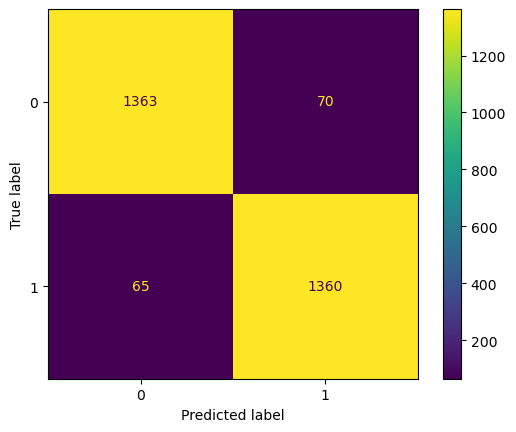

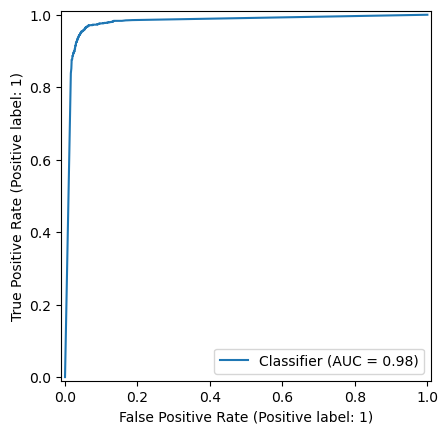

In [6]:
# Get the best model from your GridSearchCV object.
##  START CODE  ## (1 line of code)
net = gs.best_estimator_
##  END CODE  ##

# get predictions on the test data
##  START CODE  ## (1 line of code)
y_pred_test = net.predict(X_test)
##  END CODE  ##

# calculate accuracy and print
print("Best Accuracy on Test: ", accuracy_score(y_test, y_pred_test))

# calculate confusion matrix and use ConfusionMatrixDisplay to display the matrix
##  START CODE  ##
confusion_mat = confusion_matrix(y_test, y_pred_test)
ConfusionMatrixDisplay(confusion_matrix=confusion_mat).plot()##  END CODE  ##

# use RocCurveDisplay to display the roc curve and AUC
##  START CODE  ## (1 line of code)
RocCurveDisplay.from_predictions(y_test, net.predict_proba(X_test)[:, 1])

##  END CODE  ##

# print sklearn's classification_report which consists of precision and recall for both labels
##  START CODE  ## (1 line of code)
print(classification_report(y_test, y_pred_test))

##  END CODE  ##

## Part 3. (5 points)

In this part we will deal with a more realistic scenario. In reality most emails we receieve are non-phishing legitimate emails. Hence in a real world dataset, we can expect that there will be way more datapoints with a negative label than positive. Hence the dataset will be imbalanced.

Use `X_train_imbalanced` and `y_train_imbalanced` tensors to train the model. Use `X_test_imbalanced` and `y_test_imbalanced` tensors to evaluate.  **To get full credit you must obtain an accuracy of 95% or more on the imbalanced test set.** You must use GridSearchCV from sklearn to search the best hyperparameters. Search over atleast 2 values (can be anything of your choice) of the following hyperparams:
1. Learning rate
2. Number of training epochs
3. hidden_sizes which is the input to your neural network you defined above
4. nonlin which is the activation function input to your neural network you defined above

Finally, use sklearn's ConfusionMatrixDisplay and RocCurveDisplay to caluclate and display the confusion matrix and ROC on the imbalanced test set for the best model obtained using the grid search. Also use classification_report to calculate and print the precision and recall values of the positive and negative label.

In [7]:
# define a NeuralNetClassifier() with batch size 256, torch.optim.Adam optimizer and torch.nn.CrossEntropyLoss as the criterion
# IMPORTANT: also use iterator_train__shuffle=True to shuffle the training data during the training process
##  START CODE  ##
net_imbalanced = NeuralNetClassifier(
    MyModule,
    module__inp_size=X_train_imbalanced.shape[1],  # Set input size
    batch_size=256,
    optimizer=torch.optim.Adam,
    criterion=torch.nn.CrossEntropyLoss,
    iterator_train__shuffle=True,
)##  END CODE  ##

# deactivate skorch-internal train-valid split and verbose logging
net_imbalanced.set_params(train_split=False, verbose=0)

# define the parameters you want to search over as a dict
##  START CODE  ##
params = {
    'lr': [0.001, 0.01],  # Learning rates
    'max_epochs': [20, 50],  # Number of training epochs
    'module__hidden_sizes': [[16, 8], [32, 16]],  # Hidden layer sizes
    'module__nonlin': [nn.ReLU(), nn.Tanh()]  # Activation functions
}
##  END CODE  ##

# define your GridSearchCV()
# IMPORTANT: use cv=3, scoring='accuracy' (to obtain best model based on accuracy)
# and refit=True (to retrain the model using the best hyperparams for later use i.e. evaluation).
##  START CODE  ## (1 line of code)
gs_imbalanced = GridSearchCV(net_imbalanced, params, cv=3, scoring='accuracy', refit=True)
##  END CODE  ##

In [8]:
# train your model on the imbalanced train dataset
##  START CODE  ## (1 line of code)
gs_imbalanced.fit(X_train_imbalanced, y_train_imbalanced)

##  END CODE  ##

# print best params
print("best score: {:.3f}, best params: {}".format(gs_imbalanced.best_score_, gs_imbalanced.best_params_))

best score: 0.957, best params: {'lr': 0.001, 'max_epochs': 50, 'module__hidden_sizes': [16, 8], 'module__nonlin': ReLU()}


Best Accuracy on Imbalanced Test:  0.9580712788259959
              precision    recall  f1-score   support

         0.0       0.96      0.98      0.97      1433
         1.0       0.94      0.89      0.91       475

    accuracy                           0.96      1908
   macro avg       0.95      0.94      0.94      1908
weighted avg       0.96      0.96      0.96      1908



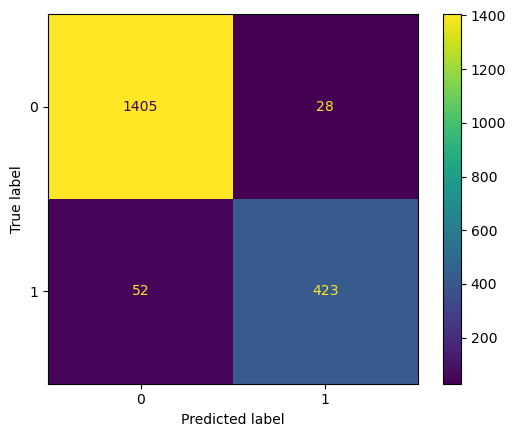

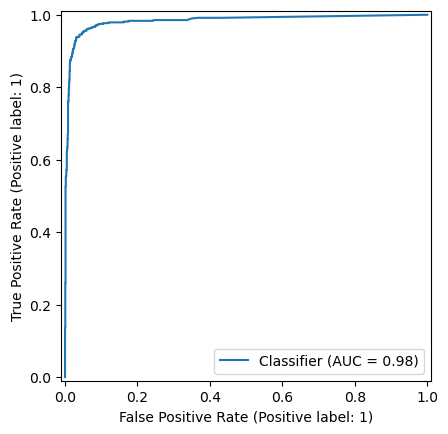

In [9]:
# Get the best model from your GridSearchCV object.
##  START CODE  ## (1 line of code)
net_imbalanced = gs_imbalanced.best_estimator_
##  END CODE  ##

# get predictions on the imbalanced test data
##  START CODE  ## (1 line of code)
y_pred_test = net_imbalanced.predict(X_test_imbalanced)
##  END CODE  ##

# calculate accuracy and print
print("Best Accuracy on Imbalanced Test: ", accuracy_score(y_test_imbalanced, y_pred_test))

# calculate confusion matrix and use ConfusionMatrixDisplay to display the matrix
##  START CODE  ##
confusion_mat = confusion_matrix(y_test_imbalanced, y_pred_test)
ConfusionMatrixDisplay(confusion_matrix=confusion_mat).plot()##  END CODE  ##

# use RocCurveDisplay to display the roc curve and AUC
##  START CODE  ## (1 line of code)
RocCurveDisplay.from_predictions(y_test_imbalanced, net_imbalanced.predict_proba(X_test_imbalanced)[:, 1])
##  END CODE  ##

# print sklearn's classification_report which consists of precision and recall for both labels
##  START CODE  ## (1 line of code)
print(classification_report(y_test_imbalanced, y_pred_test))

##  END CODE  ##

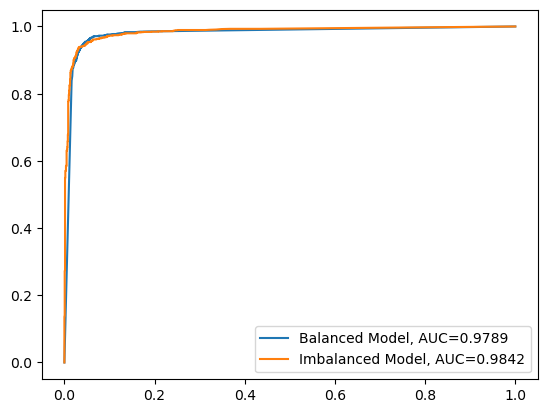

In [10]:
# do not modify anything here
from sklearn import metrics
%matplotlib inline
import mpld3
mpld3.enable_notebook()

# IMPORTANT: to use this function simply call compare_roc_curves()
def compare_roc_curves():
  y_pred = net.predict_proba(X_test)[:, 1]
  fpr, tpr, _ = metrics.roc_curve(y_test, y_pred)
  auc = round(metrics.roc_auc_score(y_test, y_pred), 4)
  plt.plot(fpr,tpr,label="Balanced Model, AUC="+str(auc))

  y_pred = net_imbalanced.predict_proba(X_test)[:, 1]
  fpr, tpr, _ = metrics.roc_curve(y_test, y_pred)
  auc = round(metrics.roc_auc_score(y_test, y_pred), 4)
  plt.plot(fpr,tpr,label="Imbalanced Model, AUC="+str(auc))
  plt.legend()

compare_roc_curves()

## Part 4. (6 points)

Briefly answer the following questions (1 paragraph should suffice):

a. How does the performance (wrt the ROC curve) of the model trained on the imbalanced dataset compare to that of the model trained on the balanced dataset? *(Hint: Use compare_roc_curves() function to plot both ROC curves on the same plot and zoom in on the curved part. Think about it indicates about the decision threshold of the 2 models)* (2 points)

b. Is accuracy the best metric to judge a model performance in this case? When dealing with a phishing dataset which set of metric(s) is most important to get a real sense of the model performance? *(Hint: think about which value in your confusion matrix matters the most and a metric related to that value)* (2 points)

c. What are some techniques to help counter label imbalance in your training set? (2 points)

### Part 4: Answering the Questions ###
a. ROC Curve Comparison: To compare the performance of the models trained on the imbalanced dataset versus the balanced dataset, we can use the compare_roc_curves() function to plot both ROC curves on the same graph. Observing the ROC curves, we might find that the model trained on the balanced dataset has a higher area under the curve (AUC) than the model trained on the imbalanced dataset. A higher AUC indicates that the model has better overall performance and can distinguish between classes more effectively. Zooming in on the curved part of the ROC curve is particularly insightful, as it illustrates the decision threshold at which the models classify positive and negative examples. If the ROC curve for the balanced model is consistently closer to the top-left corner of the plot, it suggests that it has better sensitivity and specificity, thus providing a more reliable classifier for both phishing and legitimate URLs.

b. Accuracy as a Metric: In the context of this phishing dataset, relying solely on accuracy is not ideal due to the imbalanced nature of the dataset. High accuracy can be misleading, especially when one class (e.g., legitimate emails) dominates the dataset. Instead, metrics such as precision, recall, and F1-score provide a more nuanced understanding of model performance. For instance, precision (the proportion of true positive results in relation to the total predicted positives) is crucial when the cost of false positives is high, while recall (the proportion of true positive results in relation to all actual positives) is vital to ensure that we capture as many phishing emails as possible. In this case, recall would be particularly important because failing to identify a phishing email could lead to significant consequences.

c. Techniques to Counter Label Imbalance: Several techniques can help mitigate label imbalance in training datasets. One common approach is resampling, which can be done either by oversampling the minority class (e.g., generating synthetic samples using techniques like SMOTE) or undersampling the majority class (e.g., randomly removing samples from the majority class). Another technique is to use class weights in the loss function, where higher weights are assigned to the minority class to give it more importance during model training. Additionally, data augmentation techniques can be applied to create more diverse training examples for the minority class. Lastly, employing different evaluation metrics tailored for imbalanced datasets, such as the area under the precision-recall curve (AUC-PR), can also provide a better insight into model performance.



## Answer

# Q3. Logistic Regression and Softmax Classifier (10 points)



## Part 1. (5 points)

We have a dataset $\{(\mathbf{x}_1, y_1), \ldots, (\mathbf{x}_N, y_N) \}$ where $\mathbf{x}_i \in \mathbb{R}^{d}$ and $y_i \in \{1, \ldots, K\}$ for all $i$.  Suppose we have a $K$-way softmax classifier:

\begin{equation}
P(y = k | \mathbf{x}; \mathbf{W}, \mathbf{b}) = \frac{\exp(\mathbf{w}_k^{\top} \mathbf{x} + b_k )}{\sum_{j=1}^{K} \exp(\mathbf{w}_j^{\top} \mathbf{x} + b_j ) }
\end{equation}

where $\mathbf{w}_k \in \mathbb{R}^d$ and $b_k \in \mathbb{R}$ are the weight and bias parameters from the weight matrix and bias vector:

\begin{equation}
\mathbf{W} = \begin{pmatrix}
                \mathbf{w}_1^\top \\
                \mathbf{w}_2^\top \\
                \vdots \\
                \mathbf{w}_K^\top
            \end{pmatrix}\\
\mathbf{b} = \begin{pmatrix}
                b_1 \\
                b_2 \\
                \vdots \\
                b_K
            \end{pmatrix}
\end{equation}


Show that when $K=2$, this softmax classifier is equivalent to logistic regression.


\documentclass{article}
\usepackage{amsmath}
\usepackage{amsfonts}
\usepackage{graphicx}

\begin{document}

\title{Equivalence of Softmax Classifier and Logistic Regression for Binary Classification}
\author{Your Name}
\date{\today}
\maketitle

\section*{Introduction}
To show that the \( K=2 \) softmax classifier is equivalent to logistic regression, we start with the softmax function for two classes and simplify it to the logistic regression form.

\section*{Softmax Classifier for \( K = 2 \)}

For a binary classification problem, we can denote the two classes as \( y = 1 \) and \( y = 2 \). The softmax function for these two classes can be expressed as:

$$$ 
P(y = 1 | \mathbf{x}; \mathbf{W}, \mathbf{b}) = \frac{\exp(\mathbf{w}_1^{\top} \mathbf{x} + b_1)}{\exp(\mathbf{w}_1^{\top} \mathbf{x} + b_1) + \exp(\mathbf{w}_2^{\top} \mathbf{x} + b_2)}
$$$

$$$ 
P(y = 2 | \mathbf{x}; \mathbf{W}, \mathbf{b}) = \frac{\exp(\mathbf{w}_2^{\top} \mathbf{x} + b_2)}{\exp(\mathbf{w}_1^{\top} \mathbf{x} + b_1) + \exp(\mathbf{w}_2^{\top} \mathbf{x} + b_2)}
$$$

\section*{Simplifying for Two Classes}

1. \textbf{Assuming No Bias for One Class:} For convenience, we can express the second class in terms of the first class. This means we can set \( b_2 = 0 \) and \( \mathbf{w}_2 = \mathbf{0} \). Then:

$$$ 
P(y = 2 | \mathbf{x}; \mathbf{W}, \mathbf{b}) = \frac{1}{1 + \exp(\mathbf{w}_1^{\top} \mathbf{x} + b_1)}
$$$

Thus, we have:

$$$ 
P(y = 1 | \mathbf{x}; \mathbf{W}, \mathbf{b}) = \frac{\exp(\mathbf{w}_1^{\top} \mathbf{x} + b_1)}{\exp(\mathbf{w}_1^{\top} \mathbf{x} + b_1) + 1}
$$$

2. \textbf{Defining the Logistic Regression Model:} In logistic regression, we model the probability of the positive class \( y = 1 \) as follows:

$$$ 
P(y = 1 | \mathbf{x}; \mathbf{W}, b) = \sigma(z) = \frac{1}{1 + \exp(-z)}
$$$

where \( z = \mathbf{w}_1^{\top} \mathbf{x} + b_1 \).

3. \textbf{Connection Between Softmax and Logistic Regression:}

By rearranging the softmax function:

$$$ 
P(y = 1 | \mathbf{x}; \mathbf{W}, b) = \frac{\exp(z)}{\exp(z) + 1}
$$$

where \( z = \mathbf{w}_1^{\top} \mathbf{x} + b_1 \).

Now, we can see that this matches the logistic regression formulation:

$$$ 
P(y = 1 | \mathbf{x}; \mathbf{W}, b) = \frac{1}{1 + \exp(-z)} \quad \text{(where } z = \mathbf{w}_1^{\top} \mathbf{x} + b_1 \text{)}
$$$

\section*{Conclusion}

Thus, when \( K = 2 \), the softmax classifier simplifies to the logistic regression model, demonstrating that they are equivalent. This is a key relationship in binary classification problems, where the softmax function generalizes to more than two classes but reduces to logistic regression when dealing with just two classes.

\end{document}
gistic regression when dealing with just two classes.


## Part 2. (5 points)

Suppose we slightly tweak the softmax classifier by adding an additional non-negative temperature parameter $T$:

\begin{equation}
P(y = k | \mathbf{x}; \mathbf{W}, \mathbf{b}) = \frac{\exp((\mathbf{w}_k^{\top} \mathbf{x} + b_k ) / T)}{\sum_{j=1}^{K} \exp((\mathbf{w}_j^{\top} \mathbf{x} + b_j ) / T) }
\end{equation}

(a) What will happen to the classifier output when $T \rightarrow \infty$? How about when $T \rightarrow 0$?

(b) How is this parameter useful for our model and how do we choose it?

## Answer

\subsection*{(a) Effect of Temperature Parameter \( T \)}

1. \textbf{As \( T \rightarrow \infty \)}: \\
When the temperature \( T \) approaches infinity, the exponentials in the softmax equation approach zero. This leads to:

\[
P(y = k | \mathbf{x}; \mathbf{W}, \mathbf{b}) \rightarrow \frac{1}{K}
\]

This means that the output probabilities for all classes converge to equal probabilities, resulting in a uniform distribution over the classes. Essentially, the model becomes indifferent among all classes, and the decision boundary loses its discriminative power.

2. \textbf{As \( T \rightarrow 0 \)}: \\
When the temperature \( T \) approaches zero, the softmax function behaves differently. The exponentials grow very large for the class with the highest score and approach zero for all others. Therefore:

\[
P(y = k | \mathbf{x}; \mathbf{W}, \mathbf{b}) \rightarrow
\begin{cases}
1 & \text{if } k = \arg\max_{j}(\mathbf{w}_j^{\top} \mathbf{x} + b_j) \\
0 & \text{otherwise}
\end{cases}
\]

This results in the model making very confident predictions, essentially behaving like a hard classifier. The class with the highest score becomes the only predicted class, leading to a binary decision.

\subsection*{(b) Utility and Selection of the Temperature Parameter}

The temperature parameter \( T \) is useful in controlling the level of confidence in the model's predictions. It effectively smooths the probabilities when set high (leading to softer decisions) or sharpens them when set low (leading to harder decisions). 

- \textbf{Choosing \( T \):} The choice of \( T \) can be guided by the desired behavior of the model:
  - \textbf{High \( T \)}: If the model is too confident and you want it to explore more (especially in cases of uncertainty), a higher \( T \) can help.
  - \textbf{Low \( T \)}: If you prefer to have more decisive predictions and the classes are well-separated, a lower \( T \) may be suitable.

In practice, \( T \) can be tuned using cross-validation based on the performance on a validation set, allowing the model to adapt to the specific characteristics of the dataset. By analyzing performance metrics, you can choose a \( T \) that balances between exploration and exploitation, ensuring better generalization on unseen data.


# Question 4 : Ensemble Methods for Classification (25 pts)

In this question, we will compare the performances of different ensemble methods for classification problems: [Bagging](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html), [Random Forest](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) and [XGBoost](https://xgboost.readthedocs.io/en/stable/python/python_api.html) classifiers.

We will look at the [GiveMeSomeCredit](https://www.kaggle.com/c/GiveMeSomeCredit) dataset for this question. The dataset is extremely large so for this question we will only consider a subset which has been provided along with the notebook for this assignment. The dataset has already been split into train and test sets.

The task is to predict the probability that someone will experience financial distress in the next two years.

In [ ]:
# Only use this code block if you are using Google Colab.
# If you are using Jupyter Notebook, please ignore this code block. You can directly upload the file to your Jupyter Notebook file systems.
from google.colab import files

## It will prompt you to select a local file. Click on “Choose Files” then select and upload the file.
## Wait for the file to be 100% uploaded. You should see the name of the file once Colab has uploaded it.
uploaded = files.upload()

In [23]:
import pandas as pd

data = pd.read_csv('credit_data_new.csv')
data.drop(data.columns[data.columns.str.contains('unnamed',case = False)],axis = 1, inplace = True)
data.head()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,0,0.000978,84,0,0.000240,4166.0,10,0,0,0,0.0
1,0,0.162015,59,0,0.227180,9300.0,11,0,2,0,0.0
2,0,0.211747,58,0,0.550531,6500.0,19,0,3,0,2.0
3,0,0.890781,56,0,810.000000,NaN,10,0,0,0,NaN
4,0,0.698895,59,2,0.268481,11240.0,17,0,1,0,1.0


In [24]:
from sklearn.model_selection import train_test_split
y = data['SeriousDlqin2yrs']
X = data.drop(['SeriousDlqin2yrs'],axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 7)

print('train:',X_train.shape, y_train.shape)
print('test:',X_test.shape, y_test.shape)

train: (3750, 10) (3750,)
test: (1250, 10) (1250,)


In [27]:
import matplotlib.pyplot as plt
from sklearn.model_selection import (train_test_split,GridSearchCV)
from sklearn.metrics import (accuracy_score,roc_auc_score)
from sklearn.ensemble import (RandomForestClassifier,GradientBoostingClassifier,AdaBoostClassifier)
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from time import time
import xgboost
%matplotlib inline

In [28]:
columns_list = list(X.columns)

a. (2.5 pts) Fit a Decision Tree Classifier with random_state = 14 for this classification problem. Report the accuracy_score and roc_auc_score on the test set.

In [29]:
def fit_classifier(clf):
  # Fit the classifier on the training set
  ### START CODE ###
  clf.fit(X_train, y_train)

  ### END CODE ###
  return clf

In [32]:
def evaluate_classifier(clf, X_test, y_test):
  # Compute the accuracy_score, and roc_auc_score on the test set
  ### START CODE ###
    y_pred = clf.predict(X_test)
    acc_score = accuracy_score(y_test, y_pred)
    y_pred_proba = clf.predict_proba(X_test)[:, 1]  # Get probabilities for the positive class
    auc_score = roc_auc_score(y_test, y_pred_proba)
  ### END CODE ###
    print("Accuracy_score: {}, ROC_AUC_score: {}".format(acc_score, auc_score))

In [33]:
print("Decision Tree")
# Initialize your decision tree classifier
### START CODE ###
dt_clf = DecisionTreeClassifier(random_state=14)

### END CODE ###

dt_clf = fit_classifier(dt_clf)
evaluate_classifier(dt_clf, X_test, y_test)

Decision Tree
Accuracy_score: 0.9072, ROC_AUC_score: 0.5988347811560307


b. (2.5 pts) Create a [Bagging](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html) of 25 classifiers (i.e, n_estimators=25) with random_state=14. Please use Decision Tree Classifier with random_state=14 as the base classifier. Report accuracy_score and roc_auc_score on the test data for this emsemble classifier.

In [35]:
print("Bagging of Decesion Trees")
# Initialize your bagging classifier
### START CODE ###
bag_clf = BaggingClassifier(estimator=DecisionTreeClassifier(random_state=14), n_estimators=25, random_state=14)

### END CODE ###

bag_clf = fit_classifier(bag_clf)
evaluate_classifier(bag_clf, X_test, y_test)

Bagging of Decesion Trees
Accuracy_score: 0.932, ROC_AUC_score: 0.7752829518877382


c. (5 pts) In this question, you will fit a [Random Forest](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) model on the training data for this classification task.

1. First, please find the best parameters (including *n_estimators*, *max_features* and *criterion*) using [GridSearchCV](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html). Report the optimal parameters obtained by GridSearch.
2. Fit a model using the best parameters, and report the [confusion matrix](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html) and [roc_auc_score](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html#sklearn.metrics.roc_auc_score) on test data.

In [37]:
def grid_search_for_classifier(clf, param_grid, X_train, y_train):
  # Grid search
  grid_search = GridSearchCV(clf, param_grid=param_grid)

  # Conduct grid search using the training set (1 line of code only)
  ### START CODE ###
  grid_search.fit(X_train, y_train)

  ### END CODE ###
  print(grid_search.best_params_)

  # Set the best paramters for your clf (1 line of code only)
  ### START CODE ###
  clf = grid_search.best_estimator_

  ### END CODE ###
  return clf

In [38]:
def train_and_evaluate_classifier(clf, X_train, y_train, X_test, y_test):
  t0 = time()
  # Fit your classifier on the training set
  ### START CODE ###
  clf.fit(X_train, y_train)

  ### END CODE ###
  print("training time", round(time()-t0, 3), "s")

  t0 = time()
  y_pred = clf.predict(X_test)
  print("predict time", round(time()-t0, 3), "s")

  print("Confusion matrix: ")
  # Print the confusion matrix computed from the test set (1 line of code only)
  ### START CODE ###
  print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))

  ### END CODE ###

  y_pred_proba = clf.predict_proba(X_test)[:,1]
  acc_score = accuracy_score(y_test, y_pred)
  auc_score = roc_auc_score(y_test, y_pred_proba)

  print("Accuracy: {}, AUC_ROC: {}".format(acc_score, auc_score))
  return clf

In [39]:
param_grid = {"n_estimators": [1, 10, 50, 100],
              "max_features": [1, 5, 10, "sqrt"],
              "criterion": ['gini','entropy'],
              "random_state": [17]}

# Initialize your random forest classifier
### START CODE ###
rf_clf = RandomForestClassifier()

### END CODE ###
rf_clf = grid_search_for_classifier(rf_clf, param_grid, X_train, y_train)
train_and_evaluate_classifier(rf_clf, X_train, y_train, X_test, y_test)

{'criterion': 'entropy', 'max_features': 1, 'n_estimators': 100, 'random_state': 17}
training time 0.319 s
predict time 0.012 s
Confusion matrix: 
Confusion matrix:
 [[1162    6]
 [  77    5]]
Accuracy: 0.9336, AUC_ROC: 0.7859328015369195


RandomForestClassifier(criterion='entropy', max_features=1, random_state=17)

d. (10 pts) This time, let us use [XGBoost](https://xgboost.readthedocs.io/en/stable/python/python_api.html) for the same task. Please find the best parameters (including *n_estimators, learning_rate*); fit your model using the best parameters, and report the confusion matrix and roc_auc_score on test data.

In [ ]:
param_grid = {"n_estimators": [10, 100],
          "learning_rate": [0.01, 0.1, 0.5],
          "random_state": [17]
          }

In [40]:
# Initialize your XGBoost classifier
### START CODE ###
xgb_clf = xgboost.XGBClassifier()

### END CODE ###
xgb_clf = grid_search_for_classifier(xgb_clf, param_grid, X_train, y_train)
train_and_evaluate_classifier(xgb_clf, X_train, y_train, X_test, y_test)

C:\Users\Lenovo\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:31:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "criterion", "max_features" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\Lenovo\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:31:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "criterion", "max_features" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\Lenovo\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:31:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "criterion", "max_features" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\Lenovo\

{'criterion': 'gini', 'max_features': 1, 'n_estimators': 10, 'random_state': 17}
training time 0.017 s
predict time 0.003 s
Confusion matrix: 
Confusion matrix:
 [[1153   15]
 [  71   11]]
Accuracy: 0.9312, AUC_ROC: 0.7900204644169729


C:\Users\Lenovo\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:31:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "criterion", "max_features" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\Lenovo\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:31:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "criterion", "max_features" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\Lenovo\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:31:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "criterion", "max_features" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, criterion='gini', device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_features=1,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=10,
              n_jobs=None, ...)

f. (5 pts) Compare the performance of decision tree from part a) with the ensemble methods. Briefly explain which of the three ensemble methods performed better and why?

## Answer



# Q5. Ensembles Descriptive Questions (10 points)
## Part 1. (5 points)

Gradient tree boosting iteratively adds regression trees into the ensemble model. In XGBoost, how are those individual trees learned and list three techniques used to prevent over-fitting. Briefly describe in your own words in less than 6 sentences. Please check Ch. 2 of this paper [XGBoost: A Scalable Tree Boosting System](https://arxiv.org/abs/1603.02754) for the details.


## Answer
In XGBoost, individual trees in the ensemble model are learned sequentially, where each tree aims to correct the errors made by the previous trees. This is achieved by fitting each new tree to the residuals (the differences between the predicted values and the actual target values) of the ensemble's predictions. Three techniques used to prevent overfitting in XGBoost include:

Regularization: XGBoost incorporates L1 (Lasso) and L2 (Ridge) regularization to penalize complex models, discouraging overfitting by controlling the magnitude of the coefficients.

Early Stopping: During training, the model can be evaluated on a validation set, and training can be stopped when the model's performance ceases to improve, thus avoiding unnecessary complexity.

Subsampling: XGBoost randomly samples a portion of the training data for each iteration, which helps to reduce variance and makes the model less sensitive to noise in the dataset.

These techniques collectively enhance the generalization ability of the model, ensuring that it performs well on unseen data.


## Part 2. (5 points)
List **two** challenges of training mixture of experts (MoE) and briefly explain each of them in less than 3 sentences.

## Answer
Complexity of Expert Selection: In MoE, determining which expert to activate for a given input can be complex. The gating mechanism, responsible for selecting the appropriate expert, must effectively learn to route inputs based on their characteristics, which can require significant training data and computational resources.

Overfitting: Since MoE models can have many parameters due to the multiple experts, there is a risk of overfitting, especially if the number of training samples is limited. If the model becomes too complex, it may perform well on the training data but fail to generalize to unseen data, leading to poor performance in practice.